<a href="https://colab.research.google.com/github/SameulAH/Brain-MRI-Segmentation/blob/main/Brain_MRI_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets


In [ ]:
! pip install torchview

In [ ]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from keras.callbacks import CSVLogger
import keras.backend as K
import zipfile
import pandas as pd

## Brats2020 Dataset

In [ ]:
# Create the .kaggle directory and move the kaggle.json file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation


In [ ]:
# Unzip dataset
path_to_zip_file = "brats20-dataset-training-validation.zip"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall("brats20-dataset-training-validation")

Create a small error in one file

In [ ]:
# Absolute path of the incorrectly named file
old_name = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii"

# Renaming the file
try:
    os.rename(old_name, new_name)
    print("The file has been successfully renamed")
except FileNotFoundError:
    print("Maybe you have already renamed the file or the file is not misspelled on the dataset anymore")

**EDA**



* The ground truth segmentation of the tumoral and non-tumoral regions of their brains, which has been manually realised by experts.


**  We have 4 different types of magnetic resonance imaging (MRI) scans of their brain, also known as modalities, which are named T1, T1ce, T2 and FLAIR.**




* T1-weighted MRI (T1): Provides high-resolution images of brain anatomy, excellent for visualizing normal structures and detecting lesions.
* T1-weighted contrast-enhanced MRI (T1ce): Similar to T1, but with a contrast agent to enhance visibility of tumors and areas with disrupted blood-brain barrier.
* T2-weighted MRI (T2):  Sensitive to fluid, highlighting edema and inflammation, making it useful for detecting lesions and tumors.
* FLAIR (Fluid-Attenuated Inversion Recovery): A T2-weighted sequence that suppresses cerebrospinal fluid signals, enhancing visibility of lesions near fluid spaces.



In [ ]:
# Specify a sample path (here we will take the first patient of the Training dataset)
sample_path = 'brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_'

# Load the 4 MRI modalities and the segmentation located in the patient's path using the nibabel library
t1_img=nib.load(sample_path + 't1.nii')
t1ce_img=nib.load(sample_path + 't1ce.nii')
t2_img=nib.load(sample_path + 't2.nii')
flair_img=nib.load(sample_path + 'flair.nii')
seg_img=nib.load(sample_path + 'seg.nii')

# Get the image data
t1_data = t1_img.get_fdata()
t1ce_data = t1ce_img.get_fdata()
t2_data = t2_img.get_fdata()
flair_data = flair_img.get_fdata()
seg_data = seg_img.get_fdata()

# Plot the 101th slice of the 4 RMI modalities and the segmentation
slice_nb = 101

fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs[0].set_title('T1')
axs[1].imshow(t1ce_data[:,:,slice_nb], cmap="gray")
axs[1].set_title('T1CE')
axs[2].imshow(t2_data[:,:,slice_nb], cmap="gray")
axs[2].set_title('T2')
axs[3].imshow(flair_data[:,:,slice_nb], cmap="gray")
axs[3].set_title('FLAIR')
axs[4].imshow(seg_data[:,:,slice_nb], cmap="gray")
axs[4].set_title('Segmentation')
plt.show()

For an expert, it can be useful to have these 4 modalities in order to analyze the tumor more precisely, and to confirm its presence or not.

But for our artificial approach, using only two modalities instead of four is interesting since it can reduce the computational and memory requirements of the segmentation task, making it faster and more efficient. That is why we will exclude T1, since we have its improved version T1ce. Also, we will exclude the T2 modality. Indeed, the fluids it presents could degrade our predictions. These fluids are removed in the flair version, which highlights the affected regions much better, and will therefore be much more interesting for our training.

## Images format

we can notice that these images are in .nii format. Indeed, these scans are NIfTI files (Neuroimaging Informatics Technology Initiative). A NIfTI image is a digital representation of a 3D object, such as a brain in our case.

In [8]:

# Modality shape
print(t1_data.shape)

# Segmentation shape
print(seg_data.shape)

(240, 240, 155)
(240, 240, 155)


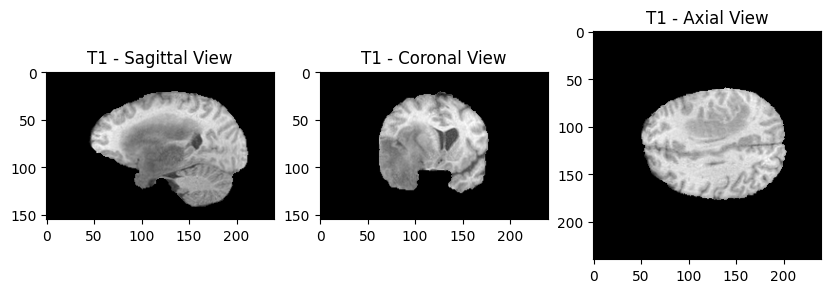

In [9]:
# Plot a RMI modality through all planes
slice_nb = 100

fig, axs2 = plt.subplots(1, 3, figsize=(10,10))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
axs2[0].imshow(rotate(t1_data[slice_nb,:,:], 90, resize=True), cmap="gray")
axs2[0].set_title('T1 - Sagittal View')

axs2[1].imshow(rotate(t1_data[:,slice_nb,:], 90, resize=True), cmap="gray")
axs2[1].set_title('T1 - Coronal View')

axs2[2].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs2[2].set_title('T1 - Axial View')

plt.show()

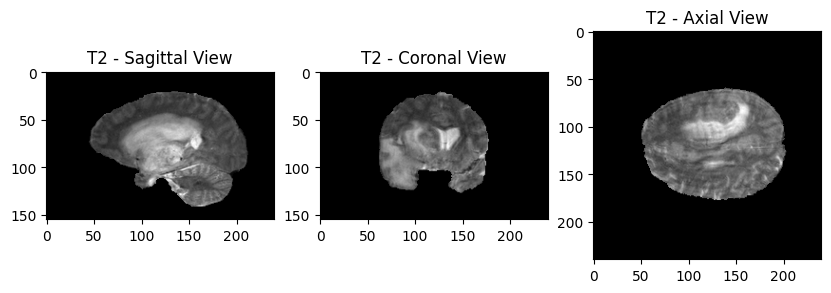

In [10]:
# Plot a RMI modality through all planes
slice_nb = 100

fig, axs2 = plt.subplots(1, 3, figsize=(10,10))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
axs2[0].imshow(rotate(t2_data[slice_nb,:,:], 90, resize=True), cmap="gray")
axs2[0].set_title('T2 - Sagittal View')

axs2[1].imshow(rotate(t2_data[:,slice_nb,:], 90, resize=True), cmap="gray")
axs2[1].set_title('T2 - Coronal View')

axs2[2].imshow(t2_data[:,:,slice_nb], cmap="gray")
axs2[2].set_title('T2 - Axial View')

plt.show()

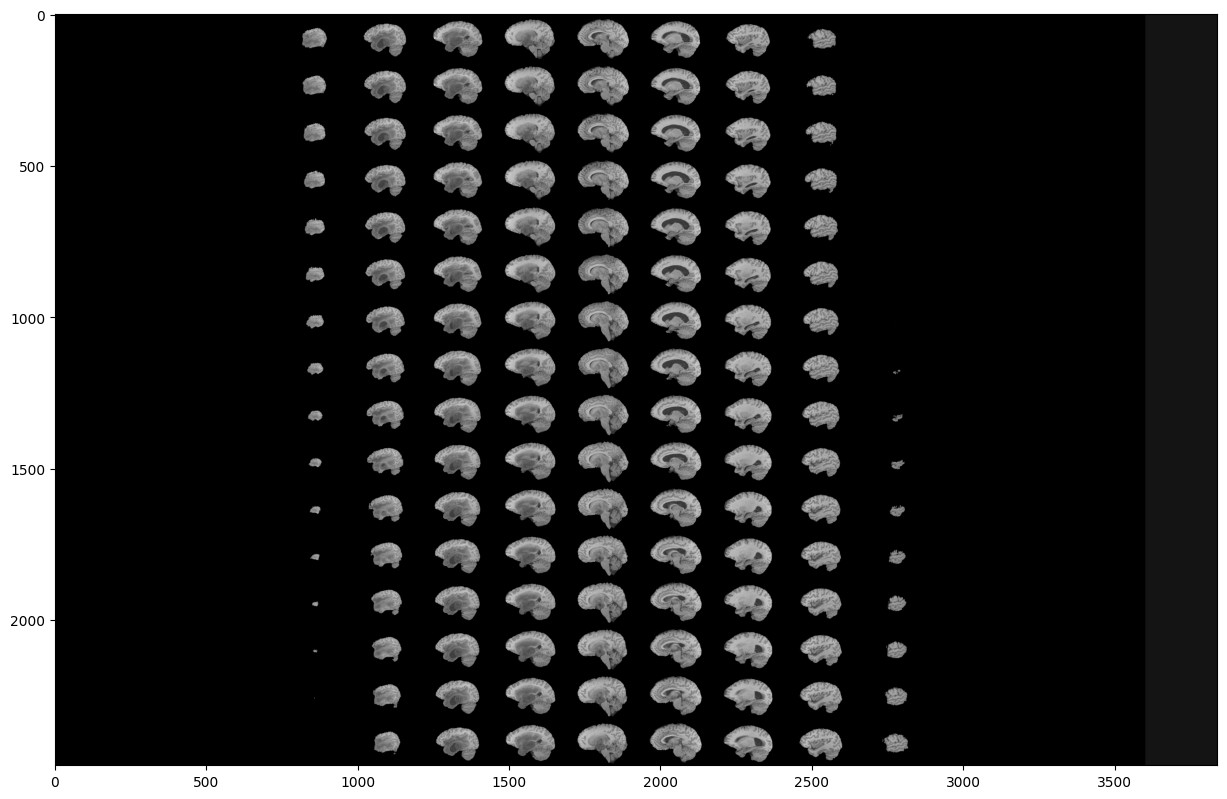

In [119]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[:,:,:]), 90, resize=True), cmap ='gray')


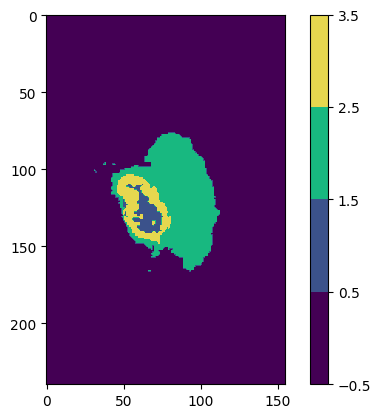

In [11]:
# Plot a segmantation
some_seg_img = nib.load("brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii").get_fdata()

cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

plt.imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
plt.colorbar()

 you will notice that some slices have multiple colors (here 4 colors), which means that the experts have assigned multiple values to the segmentation

In [12]:
data_path = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
seg_samples = [os.path.join(data_path, sample, f"{sample}_seg.nii") for sample in os.listdir(data_path) if not sample.endswith('.csv')]

saved_values = []
max_nb_values = 0
for sample in seg_samples:
    seg_img = nib.load(sample).get_fdata()
    unique_values = np.unique(seg_img)
    nb_unique_values = len(np.unique(seg_img))

    if nb_unique_values > max_nb_values:
        max_nb_values = nb_unique_values
        saved_values = unique_values

print(f"Maximum number of values in all segmentation images: {max_nb_values}")
print(f"Values: {saved_values}")

Maximum number of values in all segmentation images: 4
Values: [0. 1. 2. 4.]


we have 4 possible values in the segmentation files. These 4 values will form our 4 classes. Here is what they correspond to:

0 : Not Tumor (NT) which means Healthy Zone or Background
1 : Necrotic and Non-Enhancing Tumor (NCR + NET)
2 : Peritumoral Edema (ED)
4 : Enhancing Tumor (ET)

**Our goal is to predict and segment each of these 4 classes for new patients to find out whether or not they have a brain tumor and which areas are affected.**

Distribution of these classes in the dataset

In [31]:
values, counts = np.unique(some_seg_img, return_counts=True)
print(counts)

[8716021   15443  168794   27742]


In [ ]:
import seaborn as sns
import pandas as pd

# Create a DataFrame from the unique values and counts
data = pd.DataFrame({'Class Labels': values, 'Counts': counts})

# Create a count plot
plt.figure(figsize=(10, 5))
sns.barplot(data=data, x='Class Labels', y='Counts', palette='Blues_d')
plt.title('Class Distribution in Segmentation Image')
plt.grid(axis='y')
plt.show()


To summarize data exploration:

* We have for each sample / patient 4 different modalities (T1, T1CE, T2 & FLAIR), accompanied by a segmentation that indicates tumor areas.

* Modalities T1CE and FLAIR are the more interesting to keep, since these 2 provide complementary information about the anatomy and tissue contrast of the patient’s brain.

* Each image is 3D, and can therefore be analyzed through 3 different planes that are composed of 2D slices.

* Many slices contain little or no information. We will only keep the (60:135) slices interval for this tutorial. Of course, you are free to customize the code to send less or more slices to your model, but the training time will be longer.

* A segmentation image contains 1 to 4 classes.

* Class number 4 must be reassigned to 3 since value 3 is missing.

* Class 0 (background) is over-represented in the majority of the scans. However, cropping can remove important information. We will not use it in this tutorial and will keep the images as they are.

In [16]:

# Define selected slices range
VOLUME_START_AT = 60
VOLUME_SLICES = 75

Train-Val split

In [17]:
# Specify path of our BraTS2020 directory
data_path = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Retrieve all samples from path with listdir(). This method lists of all files + directories in the specified directory.
samples = os.listdir(data_path)
print("Number of samples:", len(samples))

Number of samples: 371


We obtain 371 files while the braTS dataset contains only 369 samples. The reason is simple: 2 .csv files are present in the MICCAI_BraTS2020_TrainingData directory

In [18]:
samples.remove("survival_info.csv")
samples.remove("name_mapping.csv")

In [19]:
# Split the dataset into train and validation sets
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)

# Split the train set into the real train set and in a test set
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

Train length: 250
Validation length: 74
Test length: 45


# Data Generator

In order to train a neural network to segment objects in images, it is necessary to feed it with both the raw image data (X) and the ground truth segmentations (y). By combining these two types of data, the neural network can learn to recognize tumor patterns and make accurate predictions about the contents of a patient’s scan.

Unfortunately, our modalities images (X) and our segmentations (y) cannot be sent directly to the AI model. Indeed, loading all these 3D images would overload the memory of our environment and cause the system to crash. This will also lead to shape mismatch errors.

** We have to do some image preprocessing before, which will be done by using a Data Generator, where we will perform any operation that we think is necessary when loading the images.**

In [39]:
import numpy as np
import os
import cv2
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.utils import Sequence

IMG_SIZE = 128
VOLUME_SLICES = 75  # Adjust based on your data
VOLUME_START_AT = 60  # Starting slice index
data_path = '/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'  # Set your data path here

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim # Resized image dimensions (128 x 128)
        self.batch_size = batch_size #  Number of images to load each time
        self.list_IDs = list_IDs # Patients IDs
        self.n_channels = n_channels # Number of channels (T1CE + FLAIR)
        self.shuffle = shuffle # Indicates if data is shuffled for each epoch
        self.on_epoch_end() # Updates indexes after each epoch

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Load & Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))

        # Generate data
        for c, i in enumerate(Batch_ids):

            # Get path of each RMI modality and the segmentation
            sample_path = os.path.join(data_path, i, i)
            t1ce_path = sample_path + '_t1ce.nii'
            flair_path = sample_path + '_flair.nii'
            seg_path = sample_path + '_seg.nii'
            #t1_path = sample_path + '_t1.nii'
            #t2_path = sample_path + '_t2.nii'

            # Extract the data from these paths
            t1ce = nib.load(t1ce_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()
            #t1 = nib.load(t1_paths).get_fdata()
            #t2 = nib.load(t2_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]

        # Masks / Segmentations
        y[y==4] = 3
        mask = tensorflow.one_hot(y, 4)
        Y = tensorflow.image.resize(mask, (IMG_SIZE, IMG_SIZE))


        print("X shape:", X.shape)
        print("Y shape:", Y.shape)


        return X/np.max(X), Y


# Assuming samples_train, samples_val, and samples_test are defined and contain your IDs
training_generator = DataGenerator(samples_train, batch_size=1)  # Set your desired batch size
valid_generator = DataGenerator(samples_val, batch_size=1)
test_generator = DataGenerator(samples_test, batch_size=1)





To summarize the preprocessing steps:

* We use a data generator to be able to process and send our data to our neural network (since all our images cannot be stored in memory at once).
* For each epoch (single pass of the entire training dataset through a neural network), the model will receive 250 samples (those contained in our training dataset).
* For each sample, the model will have to analyze 150 slices (since there are two modalities, and 75 selected slices for both of them), received in a (128, 128) shape, as an X array of a (128, 128, 75, 2) shape. This array will be provided with the ground truth segmentation of the patient, which will be One-Hot encoded and will then have a (75, 128, 128, 4) shape.

In [42]:
X, y = training_generator[0]  # Test if this works and outputs valid data
print(X.shape, y.shape)



X shape: (75, 128, 128, 2)
Y shape: (75, 128, 128, 4)
(75, 128, 128, 2) (75, 128, 128, 4)



The shapes of X and y indicate that your DataGenerator is correctly outputting data with the expected dimensions:

- X has the shape (75, 128, 128, 2), which corresponds to 75 slices of 128x128 images with 2 channels (T1CE and FLAIR).
- y has the shape (75, 128, 128, 4), indicating 75 slices of 128x128 segmentation masks with 4 classes (one-hot encoded).

# Model Training

## U-Net

In [22]:
# U-Net implementation for BraTS 2019 by Naomi Fridman, https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, 1, activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

Loss Funtion

In [32]:
# Compute metric between the predicted segmentation and the ground truth
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

We will of course use accuracy, which is a very popular measure. However, this metric can be misleading when working with imbalanced datasets like BraTS2020, where Background class is over represented. To address this issue, we will use other metrics such as the intersection over union (IoU), the Dice coefficient, precision, sensitivity, and specificity.

* Accuracy: Measures the overall proportion of correctly classified pixels, including both positive and negative pixels.

* IoU: Measures the overlap between the predicted and ground truth segmentations.

* Sensitivity (recall or true positive rate): Measures the proportion of positive ground truth pixels that were correctly predicted as positive.

* Precision (positive predictive value): Measures the proportion of predicted positive pixels that are actually positive.

* Specificity (true negative rate): Measures the proportion of negative ground truth pixels that were correctly predicted as negative.

## Model Build

In [90]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

In [89]:
# Define input data shape
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))



In [91]:
# Build and compile the model
model = build_unet(input_layer, 'he_normal', 0.2)


In [92]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Lower initial learning rate
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity]
)




In [ ]:

#def scheduler(epoch, lr):

#    if epoch < 10:
  #      return lr  # Keep the initial learning rate for the first 10 epochs
   # else:
    #    return lr * tf.math.exp(-0.1)  # Decay the learning rate exponentially

#lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)


In [93]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1),
    keras.callbacks.ModelCheckpoint('model_{epoch:02d}-{val_accuracy:.6f}.weights.h5',
                                    monitor='val_accuracy',
                                    save_best_only=True,
                                    save_weights_only = True,
                                    mode='max',
                                    verbose=1),
    CSVLogger('training.log', separator=',', append=False)
    # You can add more callbacks back one by one, such as CSVLogger or custom callbacks, to isolate the issue.
]


* ReduceLROnPlateau: This callback reduces the learning rate when a metric has stopped improving (validation loss here). The learning rate is reduced by a factor of 0.2, the patience is set to 2 epochs, and the minimum learning rate is set to 0.000001.

* ModelCheckpoint: Saves the best model weights (model that has obtained the lowest validation loss during the different epochs). Saving a model allows us to reuse it later or to share it, without having to retrain it from scratch. This will save us time and resources!

##  Train & Save the model

In [72]:
del(model)
#del(history)

In [94]:
import tensorflow as tf
from tensorflow import keras

from keras.api.layers import Dense
from keras.api.models import Sequential
from keras.api.optimizers import Adam
# Calculate steps per epoch
batch_size = 1
steps_per_epoch = len(samples_train) // batch_size
validation_steps =  len(samples_val) // batch_size


history = model.fit(training_generator,validation_data= valid_generator, epochs=33,callbacks=callbacks, verbose=1)


Streaming output truncated to the last 5000 lines.
Y shape: (75, 128, 128, 4)
101/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 407ms/step - accuracy: 0.9929 - dice_coef: 0.5576 - loss: 0.0197 - mean_io_u_6: 0.5827 - precision: 0.9939 - sensitivity: 0.9908 - specificity: 0.9979X shape: (75, 128, 128, 2)
Y shape: (75, 128, 128, 4)
102/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 407ms/step - accuracy: 0.9929 - dice_coef: 0.5579 - loss: 0.0197 - mean_io_u_6: 0.5819 - precision: 0.9939 - sensitivity: 0.9908 - specificity: 0.9979X shape: (75, 128, 128, 2)
Y shape: (75, 128, 128, 4)
103/250 ━━━━━━━━━━━━━━━━━━━━ 59s 407ms/step - accuracy: 0.9928 - dice_coef: 0.5581 - loss: 0.0197 - mean_io_u_6: 0.5811 - precision: 0.9939 - sensitivity: 0.9907 - specificity: 0.9979 X shape: (75, 128, 128, 2)
Y shape: (75, 128, 128, 4)
104/250 ━━━━━━━━━━━━━━━━━━━━ 59s 407ms/step - accuracy: 0.9928 - dice_coef: 0.5584 - loss: 0.0197 - mean_io_u_6: 0.5803 - precision: 0.9939 - sensitivity: 0.9907 - specificity: 0.9979X shape: (75, 128, 128, 2

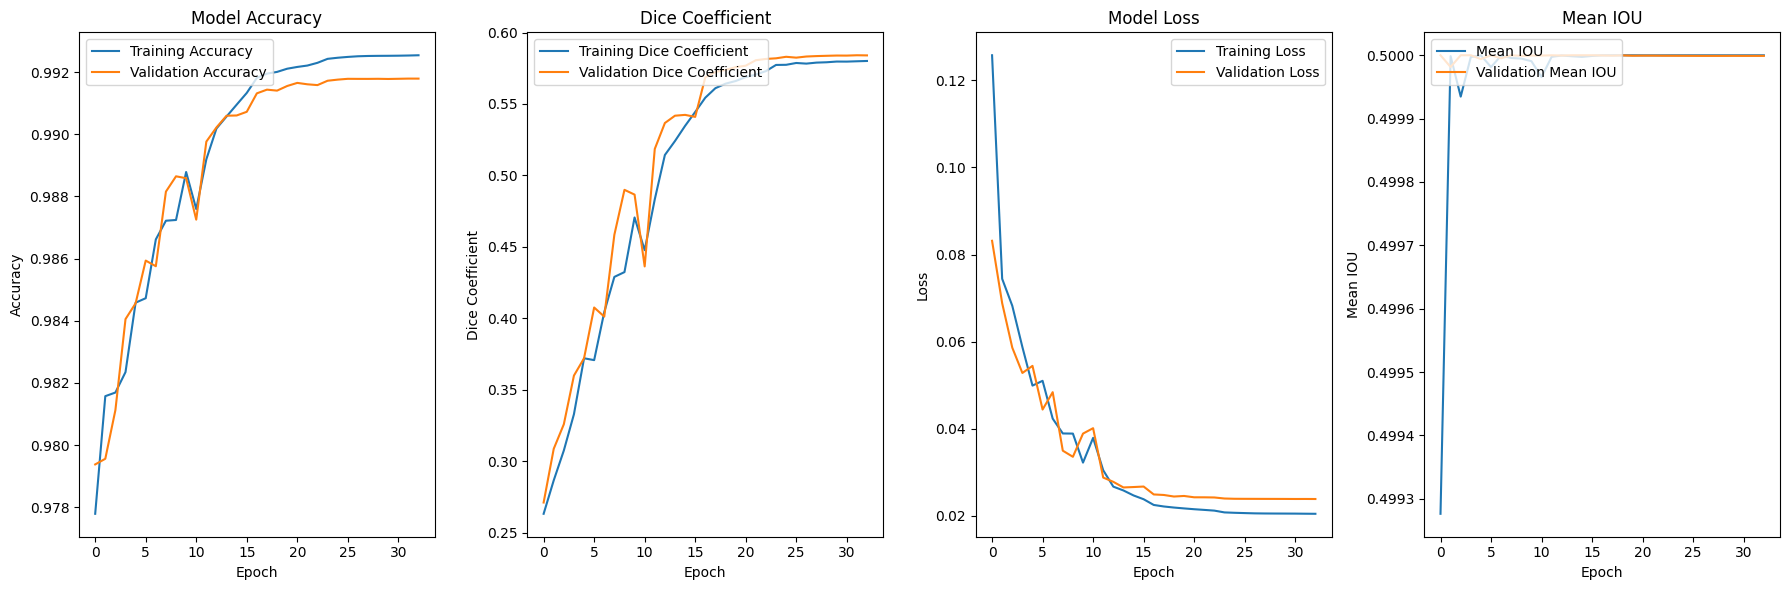

In [97]:
import matplotlib.pyplot as plt

# Plot accuracy, dice coefficient, precision, sensitivity, specificity, and loss

plt.figure(figsize=(18, 6))  # Adjusted size for 4 plots in a row

# Plot training & validation accuracy
plt.subplot(1, 4, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation dice coefficient
plt.subplot(1, 4, 2)
plt.plot(history.history['dice_coef'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coef'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend(loc='upper left')

# Plot training & validation precision
plt.subplot(1, 4, 3)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')




# Plot training & validation loss
plt.subplot(1, 4, 4)
plt.plot(history.history['mean_io_u_6'], label='Mean IOU')
plt.plot(history.history['val_mean_io_u_6'], label='Validation Mean IOU')
plt.title('Mean IOU')
plt.xlabel('Epoch')
plt.ylabel('Mean IOU')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


On the accuracy graph, we can see that both training accuracy and validation accuracy are increasing over epochs and reaching a plateau. This indicates that the model is learning from the data and generalizing well to new one.

Then, we can see that our models is clearly learning from the training data, since both losses decrease over time on the second graph.

**Predict tumor segmentations**

Now that the model is trained, it's time to use it to predict the segmentations in our test dataset!

* Use the best model's weights (from epoch 29)
* Use the final model's weights

In [98]:
# Compile a model and load our saved weights
# IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

best_saved_model = build_unet(input_layer, 'he_normal', 0.2)

best_saved_model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity] )

best_saved_model.load_weights('model_29-0.991782.weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [99]:
def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'
    #t1_path = sample_path + '_t1.nii'
    #t2_path = sample_path + '_t2.nii'

    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    # Send our images to the CNN model and return predicted segmentation
    return model.predict(X/np.max(X), verbose=1)

In [100]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    # Choose a random patient
    random_sample = random.choice(samples_list)

    # Get path of this patient
    random_sample_path = os.path.join(data_path, random_sample, random_sample)

    # Predict patient's segmentation
    predicted_seg = predict_segmentation(random_sample_path)

    # Load patient's original segmentation (Ground truth)
    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    # Differentiate segmentations by their labels
    all = predicted_seg[slice_to_plot,:,:,1:4] # Deletion of class 0 (Keep only Core + Edema + Enhancing classes)
    zero = predicted_seg[slice_to_plot,:,:,0] # Isolation of class 0, Background (kind of useless, it is the opposite of the "all")
    first = predicted_seg[slice_to_plot,:,:,1] # Isolation of class 1, Core
    second = predicted_seg[slice_to_plot,:,:,2] # Isolation of class 2, Edema
    third = predicted_seg[slice_to_plot,:,:,3] # Isolation of class 3, Enhancing

    # Plot Original segmentation & predicted segmentation
    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    # Layers 1, 2, 3
    axstest[1].imshow(all)
    axstest[1].set_title('Predicted Segmentation - all layers')

    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - layer 0')

    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - layer 1')

    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - layer 2')

    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - layer 3')

    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

**Plot Random predictions & Compare with Original (Ground truth)**


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 394ms/step
Patient number:  BraTS20_Training_273


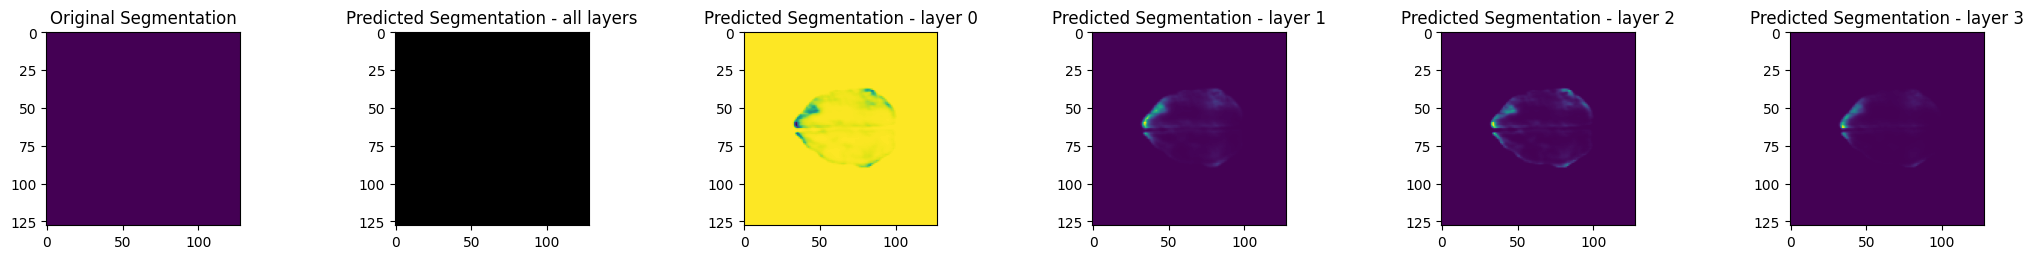

In [101]:
show_predicted_segmentations(samples_test, 60, cmap, norm)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Patient number:  BraTS20_Training_347


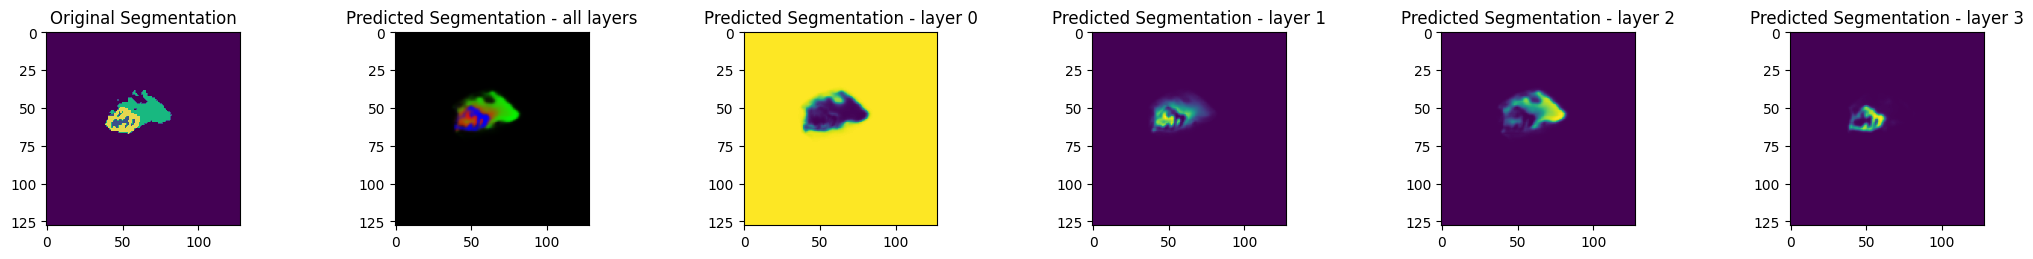

In [102]:
show_predicted_segmentations(samples_test, 50, cmap, norm)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Patient number:  BraTS20_Training_182


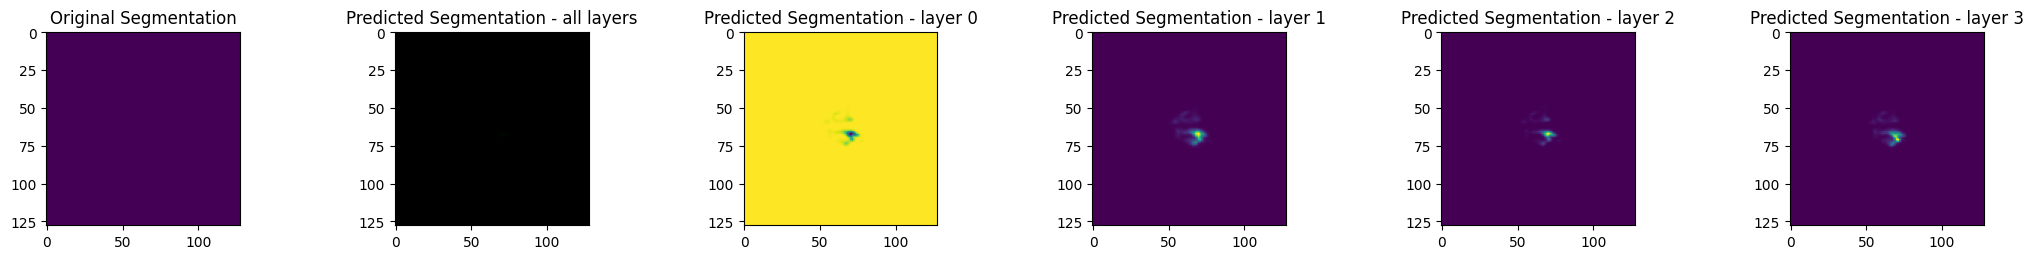

In [103]:
show_predicted_segmentations(samples_test, 70, cmap, norm)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Patient number:  BraTS20_Training_085


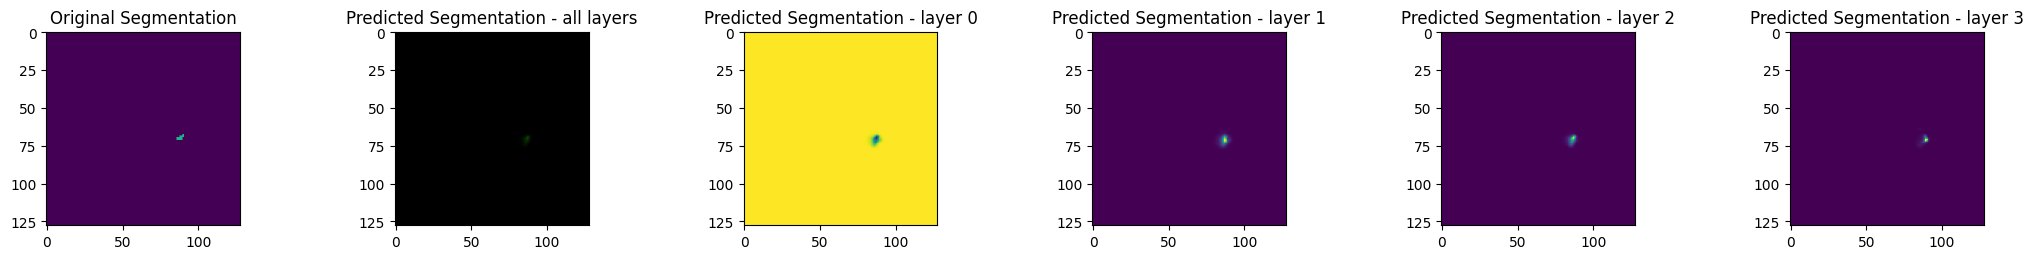

In [104]:

show_predicted_segmentations(samples_test, 70, cmap, norm)

As you can see, predicted segmentations are quite accurate.

Unfortunately, we have some false positives, which means that we detect a tumor when there is none originally present (cf 3rd plot, patient 266, slice 70).

# **Post-processing**

We are going to use the argmax decoding technique. This process consists in applying the argmax function to obtain a single label for each pixel, corresponding to the class with the highest probability. Indeed, our pixels currently have probability values for each class since they were obtained using the softmax activation function.

In [112]:
def show_post_processed_segmentations(sample, slice_to_plot, cmap, norm):

    # Get path of this patient
    sample_path = os.path.join(data_path, sample, sample)

    # Predict patient's segmentation
    predicted_seg = predict_segmentation(sample_path)

    # Load patient's original segmentation (Ground truth)
    seg_path = sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    # Fix 4 to 3 to have the same values as in the predicted segmentation, and then same colors
    seg[seg==4] = 3

    # Remove background layer (0) from original segmentation
    seg[seg==0] = np.nan

    # Post-processing
    # Get indexes for each class of the highest probability pixels. Array will then contain only [0 1 2 3] instead of probabilities
    my_pred = np.argmax(predicted_seg, axis=3)
    my_pred = my_pred[slice_to_plot, :, :]

    # Remove background layer (0) from post-processed predicted segmentation
    # To fix 0 to np.nan, we need to convert array as a float
    my_pred = my_pred.astype(float)
    my_pred[my_pred == 0] = np.nan

    # Remove background layer (0) from classical predicted segmentation
    all = predicted_seg[slice_to_plot,:,:,1:4]

    # Plot Original segmentation & predicted segmentation without processing & predicted segmentation
    print("Patient number: ", sample)
    fig, axstest = plt.subplots(1, 3, figsize=(15, 10))

    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    axstest[1].imshow(all)
    axstest[1].set_title('Prediction (w/o post processing (layer 1,2,3)')

    axstest[2].imshow(my_pred, cmap, norm)
    axstest[2].set_title('Prediction (w/ post processing (layer 1,2,3)')

    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Patient number:  BraTS20_Training_266


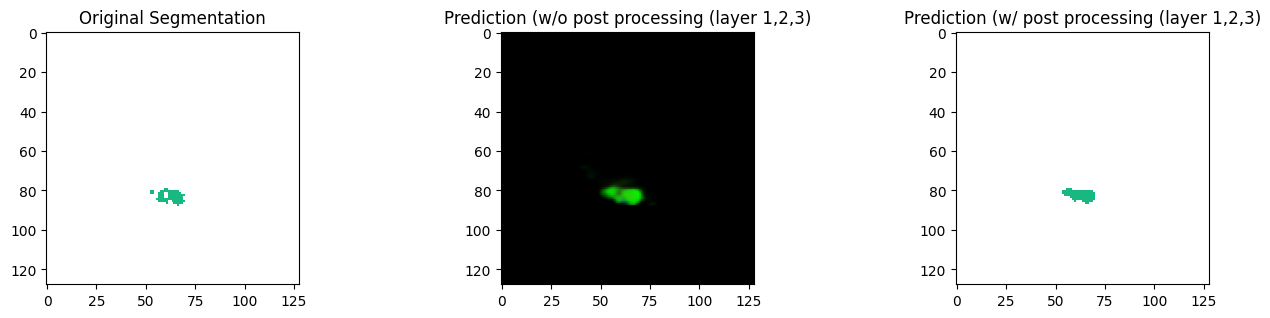

In [113]:
show_post_processed_segmentations(sample = "BraTS20_Training_266", slice_to_plot=60, cmap=cmap, norm=norm)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Patient number:  BraTS20_Training_051


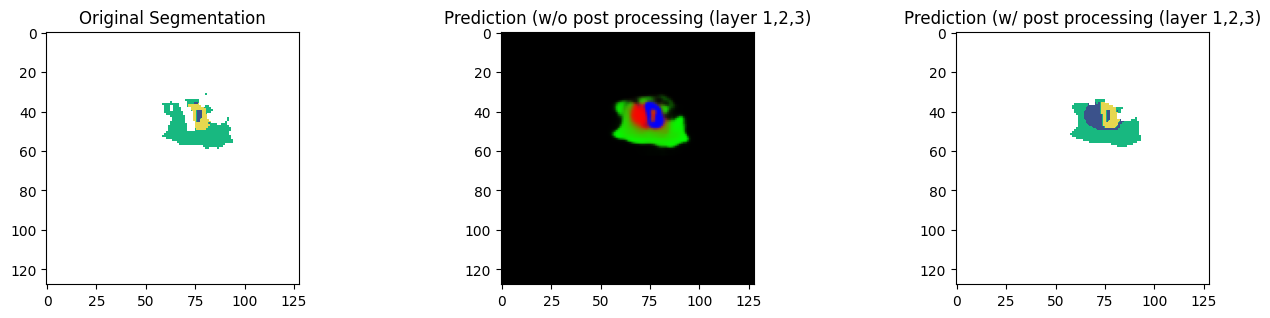

In [114]:
show_post_processed_segmentations(sample = "BraTS20_Training_051", slice_to_plot=50, cmap=cmap, norm=norm)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Patient number:  BraTS20_Training_266


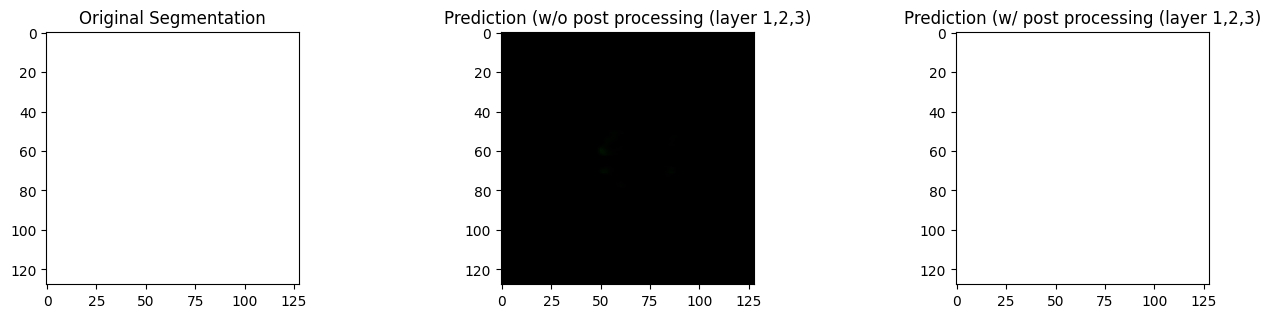

In [115]:
show_post_processed_segmentations(sample = "BraTS20_Training_266", slice_to_plot=70, cmap=cmap, norm=norm)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Patient number:  BraTS20_Training_051


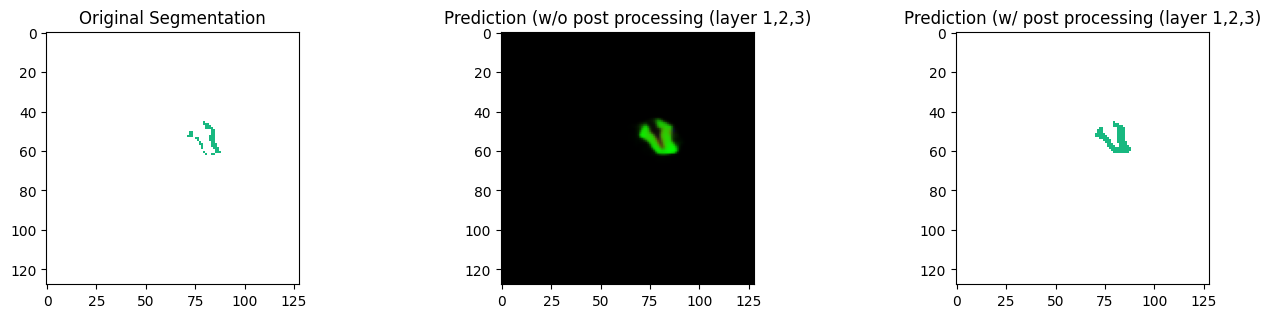

In [116]:
show_post_processed_segmentations(sample = "BraTS20_Training_051", slice_to_plot=70, cmap=cmap, norm=norm)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Patient number:  BraTS20_Training_274


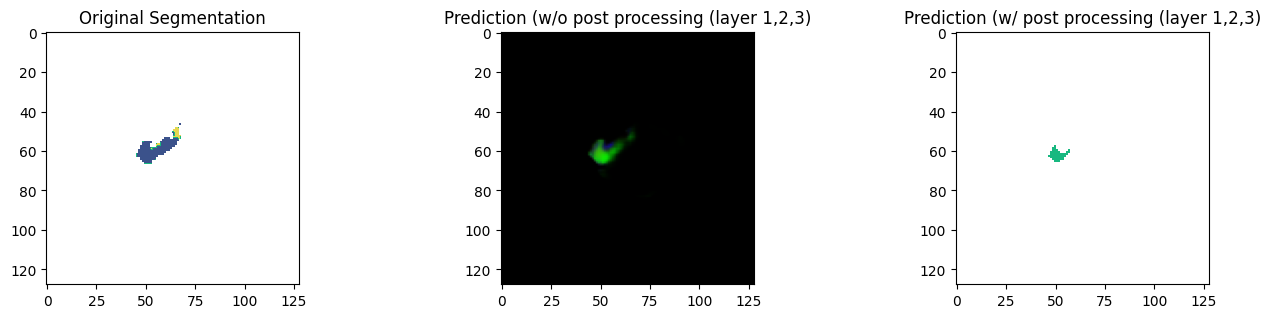

In [117]:
show_post_processed_segmentations(sample = "BraTS20_Training_274", slice_to_plot=70, cmap=cmap, norm=norm)

The argmax decoding technique seems to work pretty well! Indeed, the false positive (cf 3rd plot, patient_266, slice 70) was removed with post-processing and the other predictions were well preserved!

# **Evaluate the model**

In [118]:
# Evaluate the model on the test data

results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity"]

# Combine results list and descriptions list
results_list = zip(results, descriptions)

# Display each metric with its description
print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

X shape: (75, 128, 128, 2)
Y shape: (75, 128, 128, 4)
X shape: (75, 128, 128, 2)
Y shape: (75, 128, 128, 4)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


X shape: (75, 128, 128, 2)
Y shape: (75, 128, 128, 4)
X shape: (75, 128, 128, 2)
Y shape: (75, 128, 128, 4)
 2/45 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.9915 - dice_coef: 0.6698 - loss: 0.0275 - mean_io_u_6: 0.7904 - precision: 0.9927 - sensitivity: 0.9884 - specificity: 0.9975 X shape: (75, 128, 128, 2)
Y shape: (75, 128, 128, 4)
 3/45 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.9906 - dice_coef: 0.6390 - loss: 0.0290 - mean_io_u_6: 0.7952 - precision: 0.9920 - sensitivity: 0.9875 - specificity: 0.9972X shape: (75, 128, 128, 2)
Y shape: (75, 128, 128, 4)
 4/45 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.9908 - dice_coef: 0.6151 - loss: 0.0280 - mean_io_u_6: 0.7980 - precision: 0.9921 - sensitivity: 0.9879 - specificity: 0.9973X shape: (75, 128, 128, 2)
Y shape: (75, 128, 128, 4)
 5/45 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.9909 - dice_coef: 0.6073 - loss: 0.0276 - mean_io_u_6: 0.8014 - precision: 0.9922 - sensitivity: 0.9880 - specificity: 0.9973X shape

We can conclude that the model performed very well on the test dataset, achieving a low test loss (0.0235), a correct dice coefficient (0.57) for an image segmentation task, and good scores on other metrics which indicate that the model has good generalization performance on unseen data.